# Comparing similarity of financial text
### Using "word embeddings" to capture words with similar meanings

* There are a lot of different ways to compare the similarity of words and documents.
* This Colab notebook demonstrates **comparing the concepts** of multiple documents instead of **just comparing the words**.

###Import necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

## The issue

Computers are very, very, very particular about what counts as "the same." For example, `profit` in one document is the same as `profit` in another document, BUT the _capitalized_ version of `profit` is _not_ the same as the _lower case_ version.

In [ ]:
print('Is profit the same as profit?', "profit" == "profit")
print('Is PROFIT the same as profit?', "PROFIT" == "profit")

Is profit the same as profit? True
Is PROFIT the same as profit? False


Let's start by taking a look at "normal" document similarity that focuses just on words, then compare that approach with using ***word embeddings*** on the exact same sentences.
* Here are the sentences we'll be using:

In [ ]:
sentences = [
    'IBM stock rises after earnings announcements',
    'IBM increases on reported profits',
    'Exxon shares decline from revenue decrease',
    'Exxon lower with reduced sales'
]

print('\n'.join(sentences))

IBM stock rises after earnings announcements
IBM increases on reported profits
Exxon shares decline from revenue decrease
Exxon lower with reduced sales


**Which pair do you think is the most similar?**
* Two of them relate to the IBM's stock price increasing on improved income.
* The other two focus on Exxon's stock price decreasing on lower reported sales.

## Word counting

* To start, let's just count up the word ouccurences in each of the 4 documents.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(binary=True)
matrix = vectorizer.fit_transform(sentences)
counts = pd.DataFrame(
    matrix.toarray(),
    index=sentences,
    columns=vectorizer.get_feature_names())
counts

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,after,announcements,decline,decrease,earnings,exxon,from,ibm,increases,lower,on,profits,reduced,reported,revenue,rises,sales,shares,stock,with
IBM stock rises after earnings announcements,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
IBM increases on reported profits,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0
Exxon shares decline from revenue decrease,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0
Exxon lower with reduced sales,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1


We'll be measuring document similarity via [cosine similarity](https://www.machinelearningplus.com/nlp/cosine-similarity/), a standard measure of similarity in natural language processing. It's similar to how we might look at a graph with points at `(0,0)` and `(2,3)` and measure the distance between them - just a bit more complicated.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarities using the word counts
similarities = cosine_similarity(matrix)

# Make a fancy colored dataframe about it
pd.DataFrame(similarities,
             index=sentences,
             columns=sentences) \
            .style \
            .background_gradient(axis=None)

,IBM stock rises after earnings announcements,IBM increases on reported profits,Exxon shares decline from revenue decrease,Exxon lower with reduced sales
IBM stock rises after earnings announcements,1.000000,0.182574,0.000000,0.000000
IBM increases on reported profits,0.182574,1.000000,0.000000,0.000000
Exxon shares decline from revenue decrease,0.000000,0.000000,1.000000,0.182574
Exxon lower with reduced sales,0.000000,0.000000,0.182574,1.000000


Document similarity is on a scale of zero to one, with zero being completely dissimilar and one being an exact match. Each sentence has a `1` when compared to itself - they're totally equal!


## Word embeddings

Word embeddings are a step up from just counting words. Word embeddings give words _meaning_ to computers, teaching it that puppies are kind of like kittens, kittens are like cats, and shoes are very very different from all of those animals.

We're going to be using the [spaCy word embeddings](https://spacy.io/usage/vectors-similarity/). Each word comes with a **96-dimension vector** that expresses things like how catlike the word is, whether you can wear it, if it's something people do during a basketball game (not those exactly, but the same idea). Think of it like 96 different scores for each word, all in different categories.


In [ ]:
#!pip install spacy[transformers]
#!spacy download en_core_web_md
import spacy
#print(spacy.__file__) 
nlp = spacy.load('en')

For example, let's check out the 96 dimensions of facts and feelings that spaCy knows about the word `profit`.

In [ ]:
word1 = nlp('profit').vector  # BLUE
word2 = nlp('sales').vector   # ORANGE
word3 = nlp('swam').vector  # GREEN

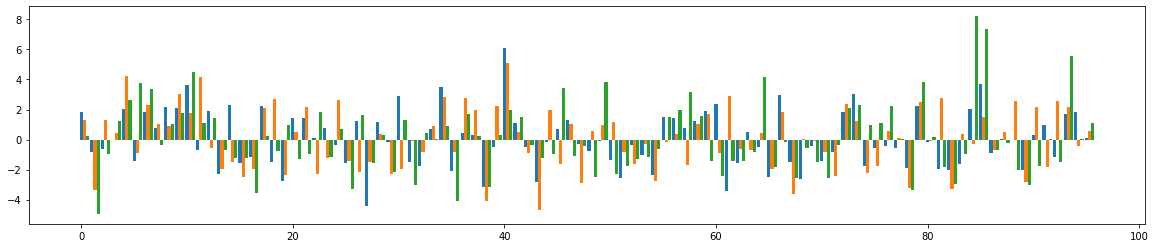

In [ ]:
width=0.3
plt.figure(figsize=(20,4))
#plt.bar(x_val, y_val1, width=width)
#plt.bar(x_val, y_val2, width=width)
plt.bar(np.arange(len(word1)), word1, width=width)
plt.bar(np.arange(len(word1))+width, word2, width=width)
plt.bar(np.arange(len(word1))+2*width, word3, width=width)

plt.show()

In the same way that each word has a 96-dimension vector, **entire sentences are just combinations of the words inside.** We can feed spaCy a sentence and it'll spit out another 96 numbers, just like it did for `cat`.

In [ ]:
nlp('cats and dogs do not get along').vector

array([-1.0932405 ,  1.6449403 ,  0.21043791, -1.6335632 ,  1.0646788 ,
        0.30831435,  0.1035098 ,  0.03718032,  1.5392387 ,  2.1258945 ,
       -0.47286865,  1.3256236 ,  1.1307312 , -0.6633233 ,  0.12991476,
        1.4132024 , -0.6934737 ,  0.31755653,  0.9085254 , -1.0248829 ,
       -0.4939215 ,  1.7706983 , -1.2963477 , -0.15207243,  0.19991735,
        0.412442  ,  0.14747296, -0.08502694,  0.2602989 , -1.3530872 ,
        1.3919003 , -1.0085694 , -1.1822277 , -0.39977932,  1.4235886 ,
        0.5934362 ,  0.16334496,  0.11931906, -2.2430892 ,  0.4102122 ,
        0.6984095 ,  0.64329135, -0.8527289 , -1.9269449 ,  1.0784557 ,
        0.10822102,  0.46923766, -0.4482821 , -0.87215674,  0.19269714,
        0.9897855 , -0.14976609, -1.0139267 , -0.01431601, -1.569678  ,
       -0.33195448,  0.33750576,  0.59800446, -0.01138267,  0.6153113 ,
        1.9581233 ,  0.9970264 , -0.724759  , -1.1564096 ,  1.141292  ,
       -1.0515397 ,  1.0991541 , -0.06567138,  0.26000813, -0.15


In order to find the similarity of each of our sentences, we'll need to conver them each into vectors.

In [ ]:
# We aren't printing this because it's 3 * 300 = 900 numbers
vectors = [nlp(sentence).vector for sentence in sentences]

# Print out some notes about it
print("We have", len(vectors), "different vectors")
print("And the first one has", len(vectors[0]), "measurements")
print("And the second one has", len(vectors[1]), "measurements")
print("And the third one has", len(vectors[2]), "measurements")
print("And the fourth one has", len(vectors[3]), "measurements")

We have 4 different vectors
And the first one has 96 measurements
And the second one has 96 measurements
And the third one has 96 measurements
And the fourth one has 96 measurements


In [ ]:
# Compute similarities
similarities = cosine_similarity(vectors)

# Turn into a dataframe
pd.DataFrame(similarities,
            index=sentences,
            columns=sentences) \
            .style \
            .background_gradient(axis=None)

,IBM stock rises after earnings announcements,IBM increases on reported profits,Exxon shares decline from revenue decrease,Exxon lower with reduced sales
IBM stock rises after earnings announcements,1.000000,0.796137,0.627898,0.478869
IBM increases on reported profits,0.796137,1.000000,0.563364,0.525836
Exxon shares decline from revenue decrease,0.627898,0.563364,1.000000,0.637442
Exxon lower with reduced sales,0.478869,0.525836,0.637442,1.000000


**And there we go!** The first thing to notice is that _none of these sentences are totally dissimilar_. Last time we had multiple zeroes - this time there are none at all.

NNote that "IBM stock rises after earnings announcements" and "IBM increases on reported profits" are very similar with a score of 0.796.

Thanks to spaCy's word embeddings understanding the concepts behind the words, the computer was able to measure the similarity between "profit" and "earnings, along with "rises" and "increases." As a result we got magically high scores despite the important words not matching exactly!


## Review

In this section, we looked at how **word embeddings** can allow more in-depth comparisons between texts than just plain word counting. Word embeddings allow the computer to understance **nuance** and **conceptual similarity** as opposed to just word-by-word counting.

There are shortcomings to both word counting and word embeddings, but depending on whether you're looking for exact matches or a more conceptual pairing, **either one can be the correct choice**.
